In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
def linear(p,x):
    return p[0]*x + p[1]

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

In [3]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:", error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

## Data

In [4]:
data = pd.read_csv('./data/scattering_3.csv').sort_values(by='theta')

In [5]:
m, b, m_err, b_err = 1.50965791, -1.17649778, 0.00232081, 0.50328454

calibrate = lambda c, c_err: (m * c + b, np.sqrt(c ** 2 * m_err ** 2 + m ** 2 * c_err ** 2 + b_err ** 2))

E_prime = lambda theta : 662 / (1 + (662/511) * (1 - np.cos(theta)))

In [8]:
thetas = data['theta'] * (np.pi / 180)
channel = data['centroid'] / (data['gain'] * data['fine_gain'])
channel_err = data['centroid_err'] / (data['gain'] * data['fine_gain'])
energy, energy_err = calibrate(channel, channel_err)

## Residuals

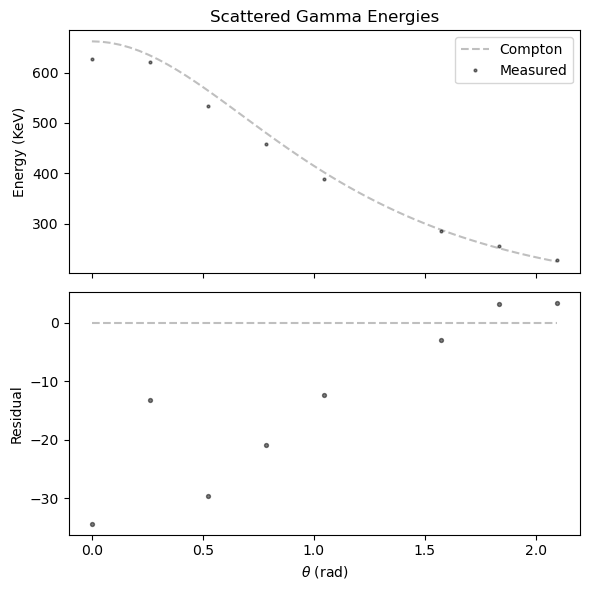

In [9]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

theta_space = np.linspace(thetas.min(), thetas.max())
ax0.errorbar(thetas, energy, fmt='k.', markersize=4, alpha=0.5, label='Measured')
ax0.plot(theta_space, E_prime(theta_space), color='k', linestyle='dashed', alpha=0.25, label='Compton')

#ax0.set_xlabel('$\\theta$ (rad)')
ax0.set_ylabel('Energy (KeV)')
ax0.set_title('Scattered Gamma Energies')
ax0.legend()

residuals = energy - E_prime(thetas)
ax1.scatter(thetas, residuals, color='k', s=8, alpha=0.5, label='Measured')
ax1.hlines(y=0, xmin=thetas.min(), xmax=thetas.max(), color='k', linestyle='dashed', alpha=0.25, label='Compton')
ax1.set_xlabel('$\\theta$ (rad)')
ax1.set_ylabel('Residual')
plt.tight_layout()

## Fit

In [10]:
def compton(p, x):
    return 662 / (1 + (662/p[0]) * (1 - np.cos(x)))

In [12]:
params_i = (511, )
params_f, params_err, chisq, dof = data_fit(
    params_i, 
    compton, 
    thetas, energy, energy_err
)


Converged with chi-squared 2530.21
Number of degrees of freedom, dof = 7.00
Reduced chi-squared 361.46

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 5.110e+02                | 4.909e+02                | 1.073e+00               


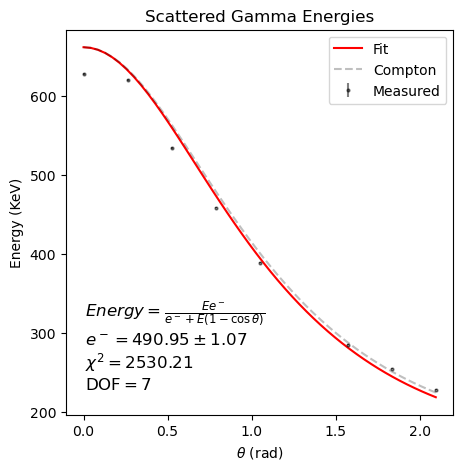

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

theta_space = np.linspace(thetas.min(), thetas.max())

ax.errorbar(thetas, energy, yerr=energy_err, fmt='k.', markersize=4, alpha=0.5, label='Measured')
ax.plot(theta_space, compton(params_f, theta_space), color='r', label='Fit')
ax.plot(theta_space, E_prime(theta_space), color='k', linestyle='dashed', alpha=0.25, label='Compton')

txt = '$Energy = \\frac{Ee^-}{e^- + E (1- \\cos \\theta)}$ \n'
txt += '$e^- = {:.2f} \\pm {:.2f}$ \n'.format(params_f[0], params_err[0])
txt += '$\\chi^2 = {:.2f}$ \n'.format(chisq)
txt += 'DOF$ = {}$'.format(dof)
ax.text(0.05, 0.3, txt, transform=ax.transAxes , fontsize=12, verticalalignment='top')

ax.set_xlabel('$\\theta$ (rad)')
ax.set_ylabel('Energy (KeV)')
ax.set_title('Scattered Gamma Energies')
ax.legend()

In [25]:
#fig.savefig('./figures/compton_fit.pdf')